### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Import functions for computing summary statistics
import resampled_stats as rs

In [3]:
# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

Set font sizes for plots

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open datasets

In [5]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray().squeeze()

In [6]:
goes_cloudmask = pd.read_pickle('data/GOES-16_ABI-L2-ACMC_CUES_2017-2020.pkl')
goes_cloudmask = goes_cloudmask.to_xarray()
# add goes_cloudmask to cues_ds
#cues_ds['goes_cloudmask'] = 

### Compute diff

(GOES Tb - CUES Tss) and add it to the dataset

In [7]:
cues_ds['goes_cues_diff'] = cues_ds.goes_tb_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

### Filter entire dataset to only snow-on conditions, and cloud-free

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where cloud_flag=0.

In [8]:
snow_depth_treshold = 5 # cm

# My original idea was to use this carefully created "cloud flag",  it seems to under-predicts true cloud cover
filter_conditions = ((cues_ds.cloud_flag == 0) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# simple Clear Sky Index > 1 means we have clouds
#filter_conditions2 = ((cues_ds.lclr_mean > cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# using the sun flag doesn't make much of a difference because the Clear Sky Index LW method i'm using here is biased towards saying we have clear skies
# when cloud_flag == 0 almost always sun_flag == 1
#filter_conditions3 = (((cues_ds.cloud_flag == 0) | (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1)) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))


cues_snow = cues_ds.where(filter_conditions)

Make a plot to preview some of this data showing snow melting away

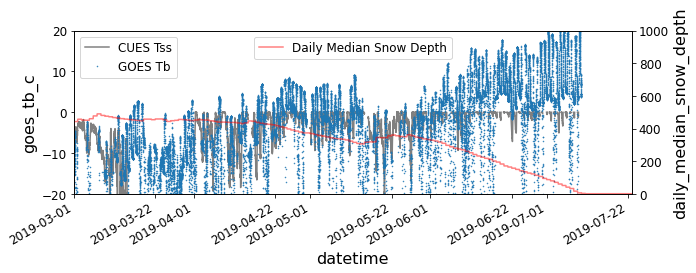

In [9]:
startdate = pd.Timestamp(2019,3,1)
enddate = pd.Timestamp(2019,7,23)

fig, ax = plt.subplots(1,1,figsize=(10,3))

cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='-', color='grey', ax=ax, label='CUES Tss')
cues_snow.goes_tb_c.plot(linestyle='none', marker='.', markersize=1, color='tab:blue', ax=ax, label='GOES Tb')
ymax = 20
ymin = -20
ax.set_ylim([ymin,ymax])

# plot the cloud mask (this is a binary, 0 or 1), multiply by ymax on the temperature scale so that it spans the plot vertically
#ax.plot(goes_cloudmask.datetime, goes_cloudmask.BCM, color='grey', alpha=0.3, label='GOES-16 Cloud Mask', zorder=0)
#ax.plot(cues_snow.datetime, cues_ds.cloud_flag,alpha=0.3, label='CUES Cloud Flag')


ax2 = ax.twinx()
ax2.set_ylim([0,1000])
cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=ax2, alpha=0.5)

ax.set_xlim([startdate,enddate])
ax.legend(loc='upper left')
ax2.legend(loc='upper center')

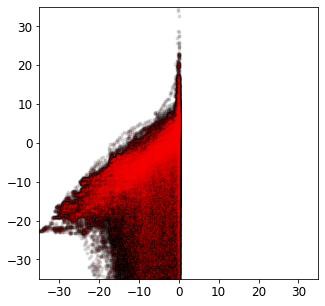

In [10]:
x1 = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_ds.goes_tb_c

x2 = cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_snow.goes_tb_c

plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.k',alpha=0.1)
plt.plot(x2, y2, '.r',alpha=0.1,markersize=1)

plt.xlim((-35,35))
plt.ylim((-35,35));

---

# Boxplots and Histograms

Resample, compute summary stats

In [12]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 1M resample

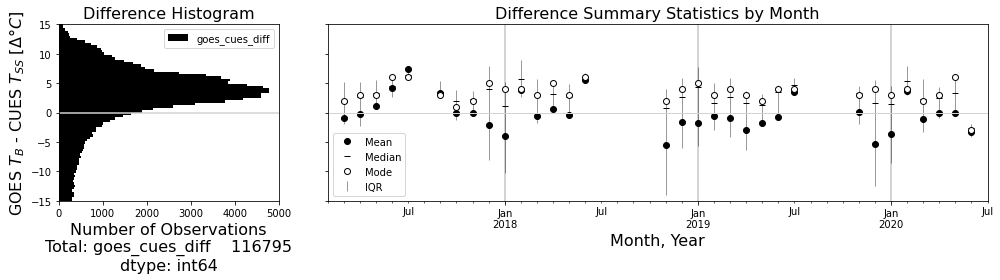

In [13]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
#fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
#ax[3].set_title('1M Resample Summary Stats')
# Plot the results2
fig, ax = rs.resampled_plot(cues_snow.goes_cues_diff.to_dataframe(), resampled_df, ymin=-15, ymax=15, xmin=0, xmax=5000, nbins=300)
# Add grid
ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
ax[1].set_xlim((pd.Timestamp('2017-02-01'),pd.Timestamp('2020-07-01')));
ax[1].set_title('Difference Summary Statistics by Month');
ax[1].set_xlabel('Month, Year');

### Month of Year groupby

Text(0.5, 0, 'Month of Year')

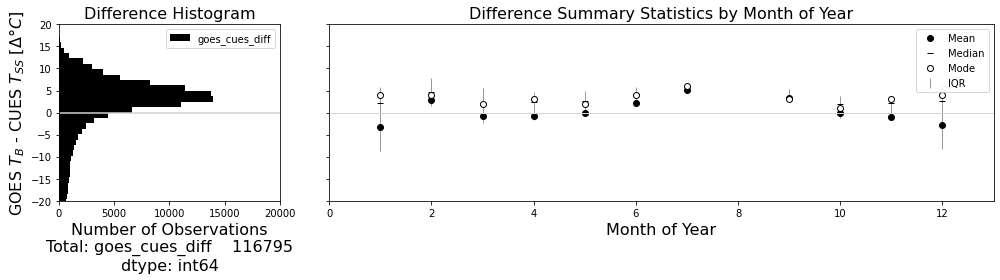

In [15]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.groupby('datetime.month')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

# Plot the results
#fig, ax = resampled_plot(resampled_df, xmin=0, xmax=10, nbins=3)
#ax[3].set_xlim((0,13)) # fix axis limits

# Plot the results2
fig, ax = rs.resampled_plot(cues_snow.goes_cues_diff.to_dataframe(), resampled_df, xmin=0, xmax=20000, nbins=100)
ax[1].set_xlim((0,13)) # fix axis limits
ax[1].set_title('Difference Summary Statistics by Month of Year')
ax[1].set_xlabel('Month of Year')

### Hour of Day, by Month-Year groupby

In [ ]:
#df = cues_snow.to_dataframe()
#
#for year in df.index.year.unique():
#    mask = df.index.year==year
#    df_n = df.loc[mask]
#    
#    for month in df_n.index.month.unique():
#        mask = df_n.index.month==month
#        df_m = df_n.loc[mask]
#
#        # Create DataArrayResample object
#        resampled_ds = df_m.goes_cues_diff.groupby(df_m.index.hour)
#        # Run the resampled_stats function
#        resampled_df = rs.resampled_stats(resampled_ds, 0)
#        
#        # Plot the results
#        #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
#        
#        # Plot the results2
#        nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
#        fig, ax = resampled_plot2(df_m.goes_cues_diff, resampled_df, ymin=-10, ymax=20, xmin=0, xmax=1000, nbins=nbins)
#        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}-{}'.format(month, year))
#        ax[1].set_xlabel('Hour of Day')

### Hour of Day, by Month groupby

In [ ]:
#df = cues_snow.to_dataframe()
#
#for month in df.index.month.unique():
#    mask = df.index.month==month
#    df_m = df.loc[mask]
#
#    # Create DataArrayResample object
#    resampled_ds = df_m.goes_cues_diff.groupby(df_m.index.hour)
#    # Run the resampled_stats function
#    resampled_df = rs.resampled_stats(resampled_ds, 0)
#    
#    # Plot the results
#    #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
#    
#    # Plot the results2
#    nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
#    fig, ax = resampled_plot2(df_m.goes_cues_diff, resampled_df, ymin=-10, ymax=20, xmin=0, xmax=2000, nbins=nbins)
#    ax[1].set_title('Difference Summary Statistics by Hour of Day for Month: {}'.format(month))
#    ax[1].set_xlabel('Hour of Day')

### Hour of Day, by Season groupby

In [16]:
for season in ['DJF', 'MAM', 'JJA']:
    df_season = cues_snow.goes_cues_diff.where(cues_snow['datetime.season']==season).to_dataframe()

    # Create DataArrayResample object
    resampled_ds = df_season.goes_cues_diff.groupby(df_season.index.hour)
    # Run the resampled_stats function
    resampled_df = rs.resampled_stats(resampled_ds, 0)
    
    # Plot the results
    #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
    
    # Plot the results2
    nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
    fig, ax = rs.resampled_plot(df_season.goes_cues_diff, resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=nbins)
    ax[1].set_title('Difference Summary Statistics by Hour of Day for Months: {}'.format(season))
    ax[1].set_xlabel('Hour of Day')

NameError: name 'df_m' is not defined